Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "meedovique"

---

# Часть 1. Гауссовы квадратуры

Метод Гауссовых квадратур является одним из методов численного интегрирования, который позволяет увеличить точность интегрирования, используя ортогональные полиномы и их корни в качестве узлов.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

здесь $\omega$ - функция весов, которая определят базис ортогональных полиномов, чьи корни используются в качестве узлов интегрирования. 

Получаемая таким образом квадратурная схема *точно* инегрирует $f(x)$ если это полином степени $m\le2n-1$, где $n$ - степень полинома, корни которого используются в качестве узлов.

## Двухточечная квадратура Гаусса

Постройте квадратурную формулу Гаусса, интегрирующую точно многочлены степеней вплоть до третьей на интервале $[a, b]$. Заметим, что для этого достаточно построить _двухточечную_ квадратуру.

    hint:Легко найти точки и веса для отрезка [-1,1], после чего можно сделать аффинное преобразование..

Напишите функцию, которая возвращает веса, $w_1$ и $w_2$, и узлы, $x_1$ и $x_2$, двухточечной квадратурной формулы Гаусса с весовой функцией $w(x) = 1$, т.е., интегралы вида

$$
\int_a^b\! f(x)\, dx \approx w_1 f(x_1) + w_2 f(x_2)
$$

In [2]:
from scipy.special import roots_legendre

def gauss_2(a, b):
    r"""Return nodes and weights for a two-point Gauss quadrature on [a, b].
    
    Parameters
    ----------
    a, b : float
       Boundaries of the integration interval
       
    Returns
    -------
    x1, x2, w1, w2 : float
       Nodes and weights of the quadrature.
    """
    nodes, weights = roots_legendre(n = 2, mu = False)
    
    mid = (a + b) / 2
    halfDiff = (b - a) / 2
    
    
    x1 = mid + nodes[0] * halfDiff
    x2 = mid + nodes[1] * halfDiff
    w1 = weights[0] * halfDiff
    w2 = weights[1] * halfDiff
    
    return x1, x2, w1, w2

In [3]:
from numpy.testing import assert_allclose

x1, x2, w1, w2 = gauss_2(0, 1)

def f(x, n): 
    return x**n

for n in [0, 1, 2, 3]:
    assert_allclose(w1*f(x1, n=n) + w2*f(x2, n=n),
                    1./(n+1), atol=1e-14)

## Использование ортогональных полиномов

### Legendre

Теперь посчитаем следующий интеграл:

$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  \label{eq1}\tag{1}
$$

Здесь функция уже полиномиальна, поэтому возьмем весовую функцию $\omega(x) = 1$. Тогда вычисление интеграла сводится к сумме корней полинома, соответствующих весовой функции $\omega(x) = 1$. Например, здесь https://dlmf.nist.gov/18.3 вы можете увидеть, какой базис полиномов соответствует вашей весовой функции.

Заметим, что нашей соответствуют полиномы Лежандра. Теперь, зайдем в документацию https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Функция *roots_legendre* сразу же выдаст корни полиномов Лежандра, а также веса к их корням (для полиномов Лежандра все эти веса равны единице).

1. Посчитайте точное значение интеграла ([1](#mjx-eqn-eq1)) "руками".

In [4]:
a = -1
b = 1

integral = lambda x: (7 / 4) * x**4 - (8 / 3) * x**3 - (3 / 2) * x**2 + 3 * x

res = integral(b) - integral(a)
res

0.6666666666666674

2. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя обычный метод интегрирования на равномерной сетке (например, написанный вами в предыдущем дз). Оцените количество узлов, необходимых для достижения относительной точности $10^{-10}$.

In [5]:
import numpy as np

def midpointRule(func, a, b, eps, compareToN = lambda n: n * 2, step = lambda n: n * 2):
    def getMidF(f, left, right): 
        return f((left + right) / 2) * (right - left)
    
    n = 1
    err = abs(eps) + 1
    while err > eps:
        allNPoints = np.linspace(a, b, num = n + 1)
        integralNPoints = np.array([getMidF(func, allNPoints[i], allNPoints[i + 1]) for i in range(n)])
        integralN = np.sum(integralNPoints)
        
        cmpN = compareToN(n)
        allCmpPoints = np.linspace(a, b, num = cmpN + 1)
        integralCmpPoints = np.array([getMidF(func, allCmpPoints[i], allCmpPoints[i + 1]) for i in range(cmpN)])
        integralCmp = np.sum(integralCmpPoints)
        
        err = abs(integralCmp - integralN)
        n = step(n)
        
    return integralN, n

func = lambda x: 7 * x ** 3 - 8 * x ** 2 - 3 * x + 3
integral, n = midpointRule(func, -1, 1, eps=1e-10)
print(f'Результат: {integral}; узлов: {n}')

Результат: 0.6666666667442769; узлов: 524288


3. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), с помощью Гауссовой квадратуры (используя корни полинома Лежандра степени от 1 до 6 в качестве узлов) (чтобы получить корни и веса используйте scipy.special.roots_legendre)

In [6]:
for i in range(1, 7):
    nodes, weights = roots_legendre(i)

    print(f'Результат: {func(nodes) @ weights}')

Результат: 6.0
Результат: 0.6666666666666674
Результат: 0.6666666666666632
Результат: 0.6666666666666667
Результат: 0.6666666666666681
Результат: 0.6666666666666694


Сравните количество узлов, необходимых для достижения одинаковой точности в обоих чисенных методах.

In [7]:
def legendre(func, eps):
    n = 0
    i = 0
    while abs(res - i) > res * eps:
            n += 1
            nodes, weights = roots_legendre(n)
            i = func(nodes) @ weights

    return i, n

for i in range(1, 11):
    eps = 10 ** (-i)
    _, n1 = legendre(func, eps)
    _, n2 = midpointRule(func, a, b, eps)
    
    print(f"Ошибка: {eps}")
    print(f"узлов Гаусса: {n1}, узлов метода с прошлого дз: {n2}\n")

Ошибка: 0.1
узлов Гаусса: 2, узлов метода с прошлого дз: 16

Ошибка: 0.01
узлов Гаусса: 2, узлов метода с прошлого дз: 64

Ошибка: 0.001
узлов Гаусса: 2, узлов метода с прошлого дз: 128

Ошибка: 0.0001
узлов Гаусса: 2, узлов метода с прошлого дз: 512

Ошибка: 1e-05
узлов Гаусса: 2, узлов метода с прошлого дз: 2048

Ошибка: 1e-06
узлов Гаусса: 2, узлов метода с прошлого дз: 4096

Ошибка: 1e-07
узлов Гаусса: 2, узлов метода с прошлого дз: 16384

Ошибка: 1e-08
узлов Гаусса: 2, узлов метода с прошлого дз: 65536

Ошибка: 1e-09
узлов Гаусса: 2, узлов метода с прошлого дз: 131072

Ошибка: 1e-10
узлов Гаусса: 2, узлов метода с прошлого дз: 524288




Вычислите значение того же интеграла, но на интервале от 0 до 10.

$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx 
$$

Заметим, что больше нельзя использовать полиномы Лежанда, потому что они определены на интервале (-1, 1). Однако всегда можно произвести *аффинное преобразование* для того, чтобы перейти к желаемой системе координат.

(20% итоговой оценки)

In [8]:
a = 0
b = 10
mid = (a + b) / 2
halfDiff = (b - a) / 2

roots, weights = roots_legendre(6)
t = halfDiff * roots + mid
i = halfDiff * func(t) @ weights
print(f'Результат: {i}')

Результат: 14713.33333333333


Сравните результат с точным значением интеграла.

Точное значение интреграла: 
$\frac{44140}{3} = 14713.(3)$ , что очень точно совпадает со значением интеграла, ошибки на уровне машинной точности

### 

Вычислите значение следующиего интеграла:
$$
\int_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}}
$$
используя соответствующий базис ортогональных полиномов.
Найдите степень полинома (количество узлов), при которой точность превысит машинное $\epsilon$.


$$ \mapsto x = 2\pi t \mapsto
\int_0^1 \frac{\cos(2\pi t)}{\sqrt{1-t^2}}\,\mathrm{d}t = 
\frac{1}{2}\int_{-1}^1 \frac{\cos(2\pi t)}{\sqrt{1-t^2}}\,\mathrm{d}t
$$ <br>
будет примерно $ 0.346010158812264 $

In [9]:
from scipy.special import roots_chebyt

iBase = 0.346010158812264
iCalc = 1
eps = 1e-15
func = lambda t: np.cos(2 * np.pi * t) / 2
n = 0
while abs(iBase - iCalc) > eps:
    n += 1
    nodes, weights = roots_chebyt(n)
    iCalc = func(nodes) @ weights

print(f'Результат: {iCalc}; за шагов: {n}')
print('Очень высокая точность')

Результат: 0.3460101588122638; за шагов: 14
Очень высокая точность


# Часть 2. Уравение Фредгольма

Существует два типа уравнений Фредгольма: 

1. Уравение Фредгольма первого рода:
$$
\int_a^b \! K(x, t)\, \color{blue}{f(t)} \,dt = g(x)
$$

2. Уравнение Фредгольма второго рода:
$$
\lambda \int_a^b\! K(x, t)\, \color{blue}{f(t)} \, dt + g(x) = \color{blue}{f(x)}
$$

Здесь функция $f(x)$ неизвестна, $K(x, t)$ - ядро уравнения, заданная функция $g(x)$ и $\lambda$ - рациональное число.
С точки зрения вычислений, уравение Фредгольма первого рода крайне неустойчиво. Далее мы рассмотрим только уравнение второго рода.

Основная идея - аппроксимировать интеграл некой квадратурной формулой

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

с подходящими весами $w_j$ и узлами $t_j$, $j=1, \dots, N$. Точность аппроксимации контролируется $N$.

Таким образом, уравнение Фредгольма приближается следующим образом:

$$
\lambda \sum_j w_j\, K(x, t_j)\, \color{blue}{f(t_j)} + g(x) = \color{blue}{f(x)}
$$

Отметим, что $x$ - непрерывная переменная, в то время, как $t$ - дискретная.

Рассматривая данное уравнение на тех же узлах сетки $x = t_k$, получаем

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k}
$$

где $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. Это ничто иное, как система линейных алгебраических уравнений на вектор $\color{blue}{f_j}$.

Ее решение выдает значение неизвестной функции $f(x)$ в дискретных точках $x=t_j$ для $j=1, \dots, N$.


Решите предложенное уравнение Фредгольма второго рода

$$
f(x) = \cos(x)  + \frac{1}{2\pi} \int_0^\pi \! \sin(x) \,t f(t) \, dt
$$

Здесь $a, b = 0, 1$, $\lambda = \dfrac{1}{2\pi}$, ядро $K(x, t) = \sin(x)\cdot t$ и правая часть - $g(x) = \cos(x)$.

Точное решение (Сборник задач по интегральным уравнениям, 2006):

$$
f(x) = \cos(x)- \frac{2}{\pi}\sin(x)
$$

Для нахождения интеграла преобразуйте заменой переменных в интеграле область интегрирования в [0,1] воспользуйтесь Гауссовой квадратурой с весовой функцией $w(x) = 1$ на $(0, 1)$. Посмотрите на http://dlmf.nist.gov/18.3, и найдите соответствующую функцию в *scipy.special* (обратите внимание на область интегрирования).

Напишите функцию, возвращающую значение f(t_j) по схеме выше, которая в качестве параметра принимает величину $N$--число узлов в квадратуре, для нахождение решения СЛАУ можно использовать `scipy.linalg.solve`.

Постройте график истинного решения и набор (t_j, f_j) для раличных $N$, используя вашу функцию.

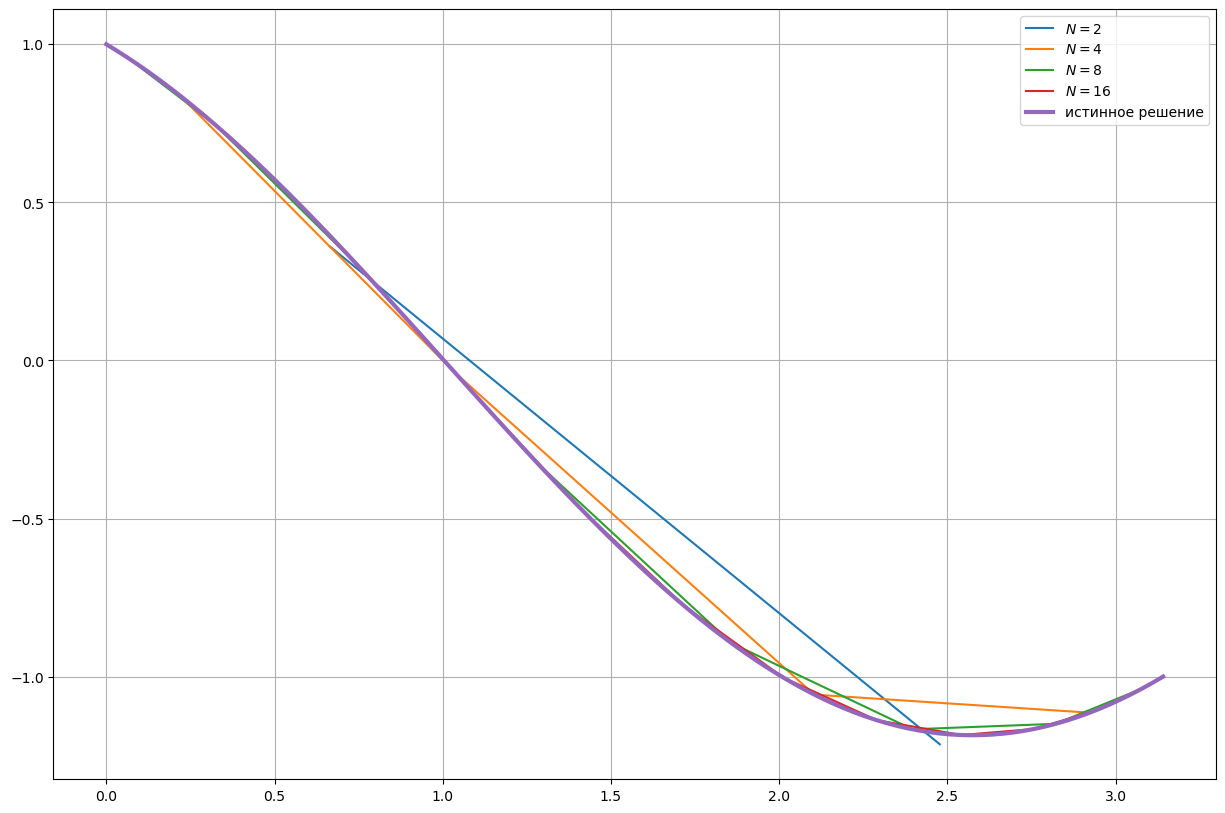

In [10]:
from scipy.special import roots_sh_legendre
from scipy.linalg import solve
import matplotlib.pyplot as plt

fBase = lambda x: np.cos(x) - 2 / np.pi * np.sin(x)
kSin = lambda x, tj: np.sin(np.pi * x) * tj
cos = lambda x: np.cos(np.pi * x)

def findF(n):
    roots, weights = roots_sh_legendre(n)

    minusG = -cos(roots)
    i = np.eye(n)
    matrixK = np.pi / 2 * np.array([weights * kSin(tk, roots) for tk in roots]) - i

    f = solve(matrixK, minusG)
    return f, roots, weights

plt.figure(figsize=(15, 10))
for n in [2, 4, 8, 16]:
    f, roots, weights = findF(n)
    x = roots * np.pi
    
    plt.plot(x, f, label=f'$N = {n}$')
    
x = np.linspace(0, np.pi, 100)
plt.plot(x, fBase(x), linewidth=3, label='истинное решение')
plt.legend()
plt.grid()
plt.show()

Очевидной проблемой предыдущего результата для $f(x)$ является то, что он возвращает решения на фиксированном наборе точек. Мы не контролируем их расположение.

Оказывается, интерполяционные методы (мы обсудим их на следующих занятиях) работают не очень хорошо, в сравнении с следующим подходом:

Используйте изначальный вид, чтобы вычислить значение функции на всём интервале:

$$
f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)
$$

Сравните эту интерполяцию с точным решением для разлиных $N$.
(выбирайте наглядный масштаб)

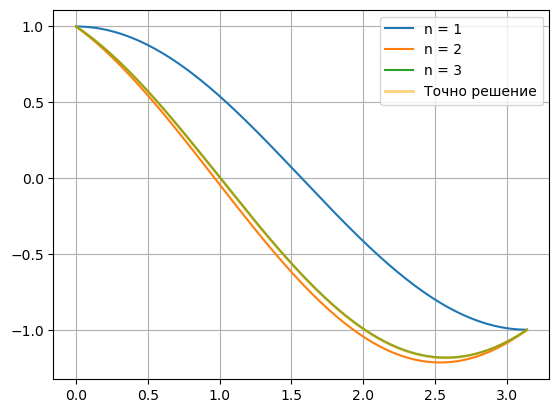

In [11]:
sample = np.linspace(0, 3.14, 150)

for n in [1, 2, 3]:
    roots, weights = roots_sh_legendre(n)
    
    fDisc, roots, weights = findF(n)
    func = lambda x: cos(x) + np.pi / 2 * (weights * kSin(x, roots) * fDisc).sum()
    fPoins = np.array([func(x) for x in sample / np.pi])
    
    plt.plot(sample, fPoins, label=f'n = {n}')

plt.plot(sample, fBase(sample), label='Точно решение', linewidth=2, alpha=0.5, c = 'orange')
plt.grid()
plt.legend()
plt.show()

# Часть 3. Интеграл от осциллирующей функции - EXTRA points task

Рассмотрим определенный интеграл

$$
I = \int_0^\infty\! \frac{\sin(x) \cos{(\cos{(x)})}}{x}\,dx
$$

Вычислите значение данного интеграла с относительной точностью $10^{-6}$. Для упрощения задачи можете воспользоваться функционалом `scipy.integrate.quad`.

Заметим, что "из коробки" интеграл вычислить не удается, и нужно что-то придумать.

In [12]:
from math import sin, cos

from scipy.integrate import quad
quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))

/tmp/ipykernel_58218/778045123.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))


(1.9653912540956746, 4.089174284042278)

Напишите функцию, которая возвращает значение данного интеграла. Только само значение интеграла, без оценки погрешности.
(оборачиваем интеграл в функцию только для удобства автопроверки).

In [13]:
from scipy.integrate import quad

def integ():
    """Return a single float, the computed value of the integral."""
    # YOUR CODE HERE
    raise NotImplementedError()

In [14]:
from numpy.testing import assert_allclose

# this is a test cell, keep it intact
